In [1]:
# !pip install warmup_scheduler
# !pip install torchlibrosa
# !pip install audiomentations

In [2]:
import librosa

In [3]:
help(librosa.mel_frequencies)

Help on function mel_frequencies in module librosa.core.convert:

mel_frequencies(n_mels: 'int' = 128, *, fmin: 'float' = 0.0, fmax: 'float' = 11025.0, htk: 'bool' = False) -> 'np.ndarray'
    Compute an array of acoustic frequencies tuned to the mel scale.
    
    The mel scale is a quasi-logarithmic function of acoustic frequency
    designed such that perceptually similar pitch intervals (e.g. octaves)
    appear equal in width over the full hearing range.
    
    Because the definition of the mel scale is conditioned by a finite number
    of subjective psychoaoustical experiments, several implementations coexist
    in the audio signal processing literature [#]_. By default, librosa replicates
    the behavior of the well-established MATLAB Auditory Toolbox of Slaney [#]_.
    According to this default implementation,  the conversion from Hertz to mel is
    linear below 1 kHz and logarithmic above 1 kHz. Another available implementation
    replicates the Hidden Markov Toolkit 

In [4]:
from audiomentations import *

In [5]:
import noisereduce as nr

/home/simon/miniconda3/envs/kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import torch
import pandas as pd
import os
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler
from timm.scheduler import CosineLRScheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import copy
import time
import os
import timm
import random
import numpy as np
import gc
import torch
import torchaudio
import torchvision
from sklearn.model_selection import StratifiedKFold
# from metrics import calculate_competition_metrics, metrics_to_string, calculate_competition_metrics_no_map
from warmup_scheduler import GradualWarmupScheduler
from torch.optim import AdamW
import albumentations as A
import matplotlib.pyplot as plt
from pylab import rcParams

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse

import sklearn
import warnings
warnings.filterwarnings("ignore")


In [7]:
def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def padded_auc(solution, submission, padding_factor=5):
    solution = solution #.drop(['row_id'], axis=1, errors='ignore')
    submission = submission #.drop(['row_id'], axis=1, errors='ignore')


    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
#     assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
#     assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

def calculate_competition_metrics(gt, preds, target_columns, one_hot=True):
    if not one_hot:
        ground_truth = np.argmax(gt, axis=1)
        gt = np.zeros((ground_truth.size, len(target_columns)))
        gt[np.arange(ground_truth.size), ground_truth] = 1
    val_df = pd.DataFrame(gt, columns=target_columns)
    pred_df = pd.DataFrame(preds, columns=target_columns)
    cmAP_1 = padded_cmap(val_df, pred_df, padding_factor=1)
    cmAP_5 = padded_cmap(val_df, pred_df, padding_factor=5)
    val_df['id'] = [f'id_{i}' for i in range(len(val_df))]
    pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
    train_score = score(val_df, pred_df, row_id_column_name='id')
    return {
      "cmAP_1": cmAP_1,
      "cmAP_5": cmAP_5,
      "ROC": train_score,
    }
def metrics_to_string(scores, key_word):
    log_info = ""
    for key in scores.keys():
        log_info = log_info + f"{key_word} {key} : {scores[key]:.4f}, "
    return log_info

## Training Logs

Epoch 1 - Train loss: 0.8522, Train cmAP_1 : 0.5357, Train cmAP_5 : 0.7442, 
Epoch 1 - Valid loss: 0.8485, Valid cmAP_1 : 0.1220, Valid cmAP_5 : 0.3257, Valid mAP : 0.0082, Valid ROC : 0.5372, 
Epoch 1 - Save Best Score: 0.5372 Model

Epoch 2 - Train loss: 0.7673, Train cmAP_1 : 0.5354, Train cmAP_5 : 0.7419, 
Epoch 2 - Valid loss: 0.6464, Valid cmAP_1 : 0.1235, Valid cmAP_5 : 0.3270, Valid mAP : 0.0129, Valid ROC : 0.5611, 
Epoch 2 - Save Best Score: 0.5611 Model

Epoch 3 - Train loss: 0.3128, Train cmAP_1 : 0.5624, Train cmAP_5 : 0.7448, 
Epoch 3 - Valid loss: 0.1051, Valid cmAP_1 : 0.0590, Valid cmAP_5 : 0.2511, Valid mAP : 0.0226, Valid ROC : 0.6110, 
Epoch 3 - Save Best Score: 0.6110 Model

Epoch 4 - Train loss: 0.0411, Train cmAP_1 : 0.5409, Train cmAP_5 : 0.7417, 
Epoch 4 - Valid loss: 0.0401, Valid cmAP_1 : 0.1435, Valid cmAP_5 : 0.3504, Valid mAP : 0.0463, Valid ROC : 0.7263, 
Epoch 4 - Save Best Score: 0.7263 Model

Epoch 5 - Train loss: 0.0350, Train cmAP_1 : 0.5427, Train cmAP_5 : 0.7459, 
Epoch 5 - Valid loss: 0.0328, Valid cmAP_1 : 0.2460, Valid cmAP_5 : 0.4553, Valid mAP : 0.2485, Valid ROC : 0.8743, 
Epoch 5 - Save Best Score: 0.8743 Model

Epoch 6 - Train loss: 0.0288, Train cmAP_1 : 0.5864, Train cmAP_5 : 0.7732, 
Epoch 6 - Valid loss: 0.0261, Valid cmAP_1 : 0.3153, Valid cmAP_5 : 0.5258, Valid mAP : 0.3372, Valid ROC : 0.9202, 
Epoch 6 - Save Best Score: 0.9202 Model

Epoch 7 - Train loss: 0.0256, Train cmAP_1 : 0.5644, Train cmAP_5 : 0.7617, 
Epoch 7 - Valid loss: 0.0274, Valid cmAP_1 : 0.3493, Valid cmAP_5 : 0.5602, Valid mAP : 0.3776, Valid ROC : 0.9380, 
Epoch 7 - Save Best Score: 0.9380 Model

Epoch 8 - Train loss: 0.0236, Train cmAP_1 : 0.5792, Train cmAP_5 : 0.7725, 
Epoch 8 - Valid loss: 0.0198, Valid cmAP_1 : 0.4676, Valid cmAP_5 : 0.6471, Valid mAP : 0.5536, Valid ROC : 0.9509, 
Epoch 8 - Save Best Score: 0.9509 Model

Epoch 9 - Train loss: 0.0223, Train cmAP_1 : 0.6052, Train cmAP_5 : 0.7826, 
Epoch 9 - Valid loss: 0.0202, Valid cmAP_1 : 0.4754, Valid cmAP_5 : 0.6594, Valid mAP : 0.5519, Valid ROC : 0.9569, 
Epoch 9 - Save Best Score: 0.9569 Model

Epoch 10 - Train loss: 0.0217, Train cmAP_1 : 0.5950, Train cmAP_5 : 0.7810, 
Epoch 10 - Valid loss: 0.0198, Valid cmAP_1 : 0.4619, Valid cmAP_5 : 0.6518, Valid mAP : 0.5328, Valid ROC : 0.9592, 
Epoch 10 - Save Best Score: 0.9592 Model

Epoch 11 - Train loss: 0.0202, Train cmAP_1 : 0.6104, Train cmAP_5 : 0.7915, 
Epoch 11 - Valid loss: 0.0166, Valid cmAP_1 : 0.5612, Valid cmAP_5 : 0.7150, Valid mAP : 0.6656, Valid ROC : 0.9641, 
Epoch 11 - Save Best Score: 0.9641 Model

Epoch 12 - Train loss: 0.0197, Train cmAP_1 : 0.5942, Train cmAP_5 : 0.7841, 
Epoch 12 - Valid loss: 0.0162, Valid cmAP_1 : 0.5966, Valid cmAP_5 : 0.7349, Valid mAP : 0.6805, Valid ROC : 0.9634, 
Valid loss didn't improve last 1 epochs.

Epoch 13 - Train loss: 0.0192, Train cmAP_1 : 0.5937, Train cmAP_5 : 0.7795, 
Epoch 13 - Valid loss: 0.0159, Valid cmAP_1 : 0.6153, Valid cmAP_5 : 0.7457, Valid mAP : 0.6893, Valid ROC : 0.9669, 
Epoch 13 - Save Best Score: 0.9669 Model

Epoch 14 - Train loss: 0.0191, Train cmAP_1 : 0.5991, Train cmAP_5 : 0.7903, 
Epoch 14 - Valid loss: 0.0193, Valid cmAP_1 : 0.5310, Valid cmAP_5 : 0.7047, Valid mAP : 0.5732, Valid ROC : 0.9660, 
Valid loss didn't improve last 1 epochs.

Epoch 15 - Train loss: 0.0180, Train cmAP_1 : 0.6038, Train cmAP_5 : 0.7822, 
Epoch 15 - Valid loss: 0.0163, Valid cmAP_1 : 0.5753, Valid cmAP_5 : 0.7283, Valid mAP : 0.6613, Valid ROC : 0.9656, 
Valid loss didn't improve last 2 epochs.

Epoch 16 - Train loss: 0.0181, Train cmAP_1 : 0.6067, Train cmAP_5 : 0.7918, 
Epoch 16 - Valid loss: 0.0168, Valid cmAP_1 : 0.5555, Valid cmAP_5 : 0.7140, Valid mAP : 0.6448, Valid ROC : 0.9613, 
Valid loss didn't improve last 3 epochs.

Epoch 17 - Train loss: 0.0176, Train cmAP_1 : 0.6181, Train cmAP_5 : 0.7918, 
Epoch 17 - Valid loss: 0.0160, Valid cmAP_1 : 0.5999, Valid cmAP_5 : 0.7436, Valid mAP : 0.6738, Valid ROC : 0.9670, 
Epoch 17 - Save Best Score: 0.9670 Model

Epoch 18 - Train loss: 0.0169, Train cmAP_1 : 0.6040, Train cmAP_5 : 0.7897, 
Epoch 18 - Valid loss: 0.0174, Valid cmAP_1 : 0.5920, Valid cmAP_5 : 0.7447, Valid mAP : 0.6454, Valid ROC : 0.9690, 
Epoch 18 - Save Best Score: 0.9690 Model

Epoch 19 - Train loss: 0.0162, Train cmAP_1 : 0.6005, Train cmAP_5 : 0.7870, 
Epoch 19 - Valid loss: 0.0174, Valid cmAP_1 : 0.5855, Valid cmAP_5 : 0.7397, Valid mAP : 0.6386, Valid ROC : 0.9682, 
Valid loss didn't improve last 1 epochs.

Epoch 20 - Train loss: 0.0161, Train cmAP_1 : 0.6355, Train cmAP_5 : 0.8080, 
Epoch 20 - Valid loss: 0.0151, Valid cmAP_1 : 0.6357, Valid cmAP_5 : 0.7629, Valid mAP : 0.7092, Valid ROC : 0.9683, 
Valid loss didn't improve last 2 epochs.

Epoch 21 - Train loss: 0.0157, Train cmAP_1 : 0.6019, Train cmAP_5 : 0.7856, 
Epoch 21 - Valid loss: 0.0162, Valid cmAP_1 : 0.5980, Valid cmAP_5 : 0.7464, Valid mAP : 0.6594, Valid ROC : 0.9675, 
Valid loss didn't improve last 3 epochs.

Epoch 22 - Train loss: 0.0160, Train cmAP_1 : 0.5569, Train cmAP_5 : 0.7717, 
Epoch 22 - Valid loss: 0.0148, Valid cmAP_1 : 0.6402, Valid cmAP_5 : 0.7668, Valid mAP : 0.7204, Valid ROC : 0.9673, 
Valid loss didn't improve last 4 epochs.

Epoch 23 - Train loss: 0.0158, Train cmAP_1 : 0.6211, Train cmAP_5 : 0.8011, 
Epoch 23 - Valid loss: 0.0150, Valid cmAP_1 : 0.6254, Valid cmAP_5 : 0.7594, Valid mAP : 0.7124, Valid ROC : 0.9642, 
Valid loss didn't improve last 5 epochs.

Epoch 24 - Train loss: 0.0153, Train cmAP_1 : 0.5914, Train cmAP_5 : 0.7817, 
Epoch 24 - Valid loss: 0.0154, Valid cmAP_1 : 0.6207, Valid cmAP_5 : 0.7590, Valid mAP : 0.6824, Valid ROC : 0.9650, 
Valid loss didn't improve last 6 epochs.

Epoch 25 - Train loss: 0.0143, Train cmAP_1 : 0.6056, Train cmAP_5 : 0.7859, 
Epoch 25 - Valid loss: 0.0155, Valid cmAP_1 : 0.6094, Valid cmAP_5 : 0.7542, Valid mAP : 0.6769, Valid ROC : 0.9680, 
Valid loss didn't improve last 7 epochs.

Early stop, Training End.


In [8]:
exp_name = 'exp1'
# backbone = 'eca_nfnet_l0'
seed = 42
batch_size =  64
num_workers = 12

n_epochs = 50
warmup_epo = 5
cosine_epo = n_epochs - warmup_epo

image_size = 256 #128 #256

lr_max = 1e-5
lr_min = 1e-7
weight_decay = 1e-6

# mel_spec_params = {
#     "sample_rate": 32000,
#     "n_mels": 128,
#     "f_min": 20,
#     "f_max": 16000,
#     "n_fft": 1024,
#     "hop_length": 320,
#     "normalized": True,
#     "center" : True,
#     "pad_mode" : "constant",
#     "norm" : "slaney",
#     "onesided" : True,
#     "mel_scale" : "slaney"
# }

mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "f_max": 16000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "onesided" : True,
    "mel_scale" : "slaney"
}

top_db = 80
train_period = 5
val_period = 5

secondary_coef = 1.0

train_duration = train_period * mel_spec_params["sample_rate"]
val_duration = val_period * mel_spec_params["sample_rate"]

N_FOLD = 5
fold = 2

use_amp = True
max_grad_norm = 10
early_stopping = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

output_folder = "outputs"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, exp_name), exist_ok=True)

## Seed Everything

In [9]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(seed)

## Data

In [10]:
ROOT = "/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input/birdclef-2024"

df = pd.read_csv(f'{ROOT}/train_metadata.csv')
df["path"] = f"{ROOT}/train_audio/" + df["filename"]
df["rating"] = np.clip(df["rating"] / df["rating"].max(), 0.1, 1.0)

skf = StratifiedKFold(n_splits=N_FOLD, random_state=seed, shuffle=True)
df['fold'] = -1
for ifold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df["primary_label"].values)):
    df.loc[val_idx, 'fold'] = ifold

sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
target_columns = sub.columns.tolist()[1:]
num_classes = len(target_columns)
bird2id = {b: i for i, b in enumerate(target_columns)}
print(bird2id)

{'asbfly': 0, 'ashdro1': 1, 'ashpri1': 2, 'ashwoo2': 3, 'asikoe2': 4, 'asiope1': 5, 'aspfly1': 6, 'aspswi1': 7, 'barfly1': 8, 'barswa': 9, 'bcnher': 10, 'bkcbul1': 11, 'bkrfla1': 12, 'bkskit1': 13, 'bkwsti': 14, 'bladro1': 15, 'blaeag1': 16, 'blakit1': 17, 'blhori1': 18, 'blnmon1': 19, 'blrwar1': 20, 'bncwoo3': 21, 'brakit1': 22, 'brasta1': 23, 'brcful1': 24, 'brfowl1': 25, 'brnhao1': 26, 'brnshr': 27, 'brodro1': 28, 'brwjac1': 29, 'brwowl1': 30, 'btbeat1': 31, 'bwfshr1': 32, 'categr': 33, 'chbeat1': 34, 'cohcuc1': 35, 'comfla1': 36, 'comgre': 37, 'comior1': 38, 'comkin1': 39, 'commoo3': 40, 'commyn': 41, 'compea': 42, 'comros': 43, 'comsan': 44, 'comtai1': 45, 'copbar1': 46, 'crbsun2': 47, 'cregos1': 48, 'crfbar1': 49, 'crseag1': 50, 'dafbab1': 51, 'darter2': 52, 'eaywag1': 53, 'emedov2': 54, 'eucdov': 55, 'eurbla2': 56, 'eurcoo': 57, 'forwag1': 58, 'gargan': 59, 'gloibi': 60, 'goflea1': 61, 'graher1': 62, 'grbeat1': 63, 'grecou1': 64, 'greegr': 65, 'grefla1': 66, 'grehor1': 67, 'grej

## Dataset

In [11]:
def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V


def SpectralNoiseReduction(audio_data, sr, min_length_sec=5):
    # Skip processing if the length of the audio data is less than the specified minimum length in seconds
    if len(audio_data) < sr * min_length_sec:
        return audio_data

    # Calculate the transition of noise levels across the audio data using a window size of 3 seconds and an overlap of 1.5 seconds
    hop_length = int(sr * 1.5)  # 1.5 seconds overlap
    win_length = int(sr * 3)    # 3 seconds window size
    rms = librosa.feature.rms(y=audio_data, frame_length=win_length, hop_length=hop_length)

    # Identify the time with the smallest noise level
    noise_sec = 1  # noise reference length in seconds
    min_rms_idx = np.argmin(rms)  # index of the minimum RMS value
    start_idx = min_rms_idx * hop_length
    end_idx = start_idx + sr * noise_sec  # Extract 1 second of data around the time of minimum noise

    # Adjust the indices to make sure they are within the bounds of the audio data
    start_idx = max(0, start_idx)  # Ensure start index is not negative
    end_idx = min(len(audio_data), end_idx)  # Ensure end index does not exceed the length of the audio data

    # Use the extracted data as the reference noise data
    noise_data = audio_data[start_idx:end_idx]

    # Perform noise reduction
    return nr.reduce_noise(y=audio_data, sr=sr, y_noise=noise_data)

def read_wav(path):
    wav, org_sr = torchaudio.load(path, normalize=True)
    wav = SpectralNoiseReduction(wav,sr=org_sr)
    wav = torchaudio.functional.resample(wav, orig_freq=org_sr, new_freq=mel_spec_params["sample_rate"])
    return wav


def crop_start_wav(wav, duration_):
    while wav.size(-1) < duration_:
        wav = torch.cat([wav, wav], dim=1)
    wav = wav[:, :duration_]
    return wav

def crop_random_wav(wav, duration_):
    while wav.size(-1) < duration_:
        wav = torch.cat([wav, wav], dim=1)
    start = np.random.randint(wav.shape[1]-duration_)
    wav = wav[:, start:start+duration_]
    return wav

def random_power(images, power=1.5, c=0.7):
    images = images - images.min()
    images = images / (images.max() + 0.0000001)
    images = images ** (random.random() * power + c)
    return images

class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, add_secondary_labels=True, mode="train"):
        self.df = df
        self.bird2id = bird2id
        self.num_classes = num_classes
        self.secondary_coef = secondary_coef
        self.add_secondary_labels = add_secondary_labels
        self.mel_transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=top_db)
        self.transform = transform
        self.mode = mode
        
        if mode == "train":
            self.wave_transforms = A.Compose(
                [
#                     OneOf([
#                         Gain(min_gain_in_db=-15, max_gain_in_db=15, p=0.8),
#                         GainTransition(min_gain_in_db=-15, max_gain_in_db=15, p=0.8),
#                     ]),
#                     OneOf(
#                         [
#                             NoiseInjection(p=1, max_noise_level=0.04),
#                             GaussianNoise(p=1, min_snr=5, max_snr=20),
#                             PinkNoise(p=1, min_snr=5, max_snr=20),
#                             AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.03, p=0.5),
#                             AddGaussianSNR(min_snr_in_db=5, max_snr_in_db=15, p=0.5),
#                         ],
#                         p=0.3,
#                     ),
                    AddBackgroundNoise(
                        sounds_path="/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/input/backgroud_noise/archive/birdclef2021_nocall", min_snr_in_db=0, max_snr_in_db=2, p=0.5
                    ),
                    A.Normalize(p=1),
                ]
            )
        else:
            self.wave_transforms = Compose(
                [
                    Normalize(p=1),
                ]
            )

    def __len__(self):
        return len(self.df)

    def prepare_target(self, primary_label, secondary_labels):
        secondary_labels = eval(secondary_labels)
        target = np.zeros(self.num_classes, dtype=np.float32)
        if primary_label != 'nocall':
            primary_label = self.bird2id[primary_label]
            target[primary_label] = 1.0
            if self.add_secondary_labels:
                for s in secondary_labels:
                    if s != "" and s in self.bird2id.keys():
                        target[self.bird2id[s]] = self.secondary_coef
        target = torch.from_numpy(target).float()
        return target
    
    def prepare_spec(self, path):
        wav = read_wav(path)
        if self.mode=='train':
            wav = crop_start_wav(wav, train_duration)
        else:
            wav = crop_start_wav(wav, train_duration)
        if self.wave_transforms:
            ttt = self.wave_transforms(wav[0, :].numpy(), sample_rate=32000)
            print(ttt)
            wav[0, :] = torch.tensor(ttt).float() #self.wave_transforms(wav[0, :], sample_rate=32000)
        tmp = self.mel_transform(wav)
        if self.mode=="train":
            tmp[0, :] = random_power(tmp[0, :], power=3, c=0.5)
#         print(tmp.shape)
        mel_spectrogram = normalize_melspec(self.db_transform(tmp))
        mel_spectrogram = mel_spectrogram * 255
        mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()
        return mel_spectrogram

#     def prepare_spec(self, path):
#         wav = read_wav(path)
#         wav = crop_start_wav(wav, train_duration)
#         mel_spectrogram = normalize_melspec(self.db_transform(self.mel_transform(wav)))
#         mel_spectrogram = mel_spectrogram * 255
#         mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()
#         return mel_spectrogram

    def __getitem__(self, idx):
        path = self.df["path"].iloc[idx]
        primary_label = self.df["primary_label"].iloc[idx]
        secondary_labels = self.df["secondary_labels"].iloc[idx]
        rating = self.df["rating"].iloc[idx]

        spec = self.prepare_spec(path)
        target = self.prepare_target(primary_label, secondary_labels)

        if self.transform is not None:
            res = self.transform(image=spec)
            spec = res['image'].astype(np.float32)
        else:
            spec = spec.astype(np.float32)

        spec = spec.transpose(2, 0, 1)

        return {"spec": spec, "target": target, 'rating': rating}


In [12]:
def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V


def read_wav(path):
    wav, org_sr = torchaudio.load(path, normalize=True)
    wav = torchaudio.functional.resample(wav, orig_freq=org_sr, new_freq=mel_spec_params["sample_rate"])
    return wav


def crop_start_wav(wav, duration_):
    while wav.size(-1) < duration_:
        wav = torch.cat([wav, wav], dim=1)
    wav = wav[:, :duration_]
    return wav


class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, add_secondary_labels=True):
        self.df = df
        self.bird2id = bird2id
        self.num_classes = num_classes
        self.secondary_coef = secondary_coef
        self.add_secondary_labels = add_secondary_labels
        self.mel_transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=top_db)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def prepare_target(self, primary_label, secondary_labels):
        secondary_labels = eval(secondary_labels)
        target = np.zeros(self.num_classes, dtype=np.float32)
        if primary_label != 'nocall':
            primary_label = self.bird2id[primary_label]
            target[primary_label] = 1.0
            if self.add_secondary_labels:
                for s in secondary_labels:
                    if s != "" and s in self.bird2id.keys():
                        target[self.bird2id[s]] = self.secondary_coef
        target = torch.from_numpy(target).float()
        return target
    
    def remove_below_300Hz(self, mel_spectrogram, sr):
        
        # 计算Mel频谱图对应的频率
        mel_freqs = librosa.mel_frequencies(n_mels=mel_spectrogram.shape[0], fmin=0, fmax=sr/2)
        
        # 找到低于300Hz的频率对应的索引
        idx_to_remove = np.where(mel_freqs < 300)[0]
        
        # 将低于300Hz的部分替换为最小值
        mel_spectrogram_filtered = np.copy(mel_spectrogram)
        mel_spectrogram_filtered[idx_to_remove, :] = np.min(mel_spectrogram)
        
        return mel_spectrogram_filtered
    def prepare_spec(self, path):
        wav = read_wav(path)
        wav = crop_start_wav(wav, train_duration)
        mel_spectrogram = normalize_melspec(self.db_transform(self.mel_transform(wav)))
        mel_spectrogram = mel_spectrogram * 255
        mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()
        return mel_spectrogram

    def __getitem__(self, idx):
        path = self.df["path"].iloc[idx]
        primary_label = self.df["primary_label"].iloc[idx]
        secondary_labels = self.df["secondary_labels"].iloc[idx]
        rating = self.df["rating"].iloc[idx]

        spec = self.prepare_spec(path)
        target = self.prepare_target(primary_label, secondary_labels)

        if self.transform is not None:
            res = self.transform(image=spec)
            spec = res['image'].astype(np.float32)
        else:
            spec = spec.astype(np.float32)

        spec = spec.transpose(2, 0, 1)

        return {"spec": spec, "target": target, 'rating': rating}


## Model

In [13]:
CNN_ = False

In [14]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x


class CNN(torch.nn.Module):
    def __init__(self, backbone, pretrained):
        super().__init__()

        out_indices = (3, 4)
        self.backbone = timm.create_model(
            backbone,
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=num_classes,
            out_indices=out_indices,
        )
        feature_dims = self.backbone.feature_info.channels()
        print(f"feature dims: {feature_dims}")

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.head = torch.nn.Linear(self.mid_features, num_classes)

    def forward(self, x):
#         print(x.shape)
        ms = self.backbone(x)
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.head(x)
#         print(x.shape)
        return x


In [15]:
import random

import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchlibrosa.augmentation import SpecAugmentation


def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    output = F.interpolate(
        framewise_output.unsqueeze(1),
        size=(frames_num, framewise_output.size(2)),
        align_corners=True,
        mode="bilinear").squeeze(1)

    return output


class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)


class TimmSED(nn.Module):
    def __init__(
            self,
            base_model_name: str,
            config=None,
            pretrained=False,
            num_classes=24,
            in_channels=1
    ):
        super().__init__()

        self.config = config

        self.spec_augmenter = SpecAugmentation(
            time_drop_width=64 // 2,
            time_stripes_num=2,
            freq_drop_width=8 // 2,
            freq_stripes_num=2
        )

        self.bn0 = nn.BatchNorm2d(self.config.n_mels)

        base_model = timm.create_model(
            base_model_name,
            pretrained=pretrained,
            in_chans=in_channels,
        )

        layers = list(base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        if "eca_nfnet_l0" == base_model_name:
            in_features = base_model.num_features
        elif hasattr(base_model, "fc"):
            in_features = base_model.fc.in_features
        else:
            in_features = base_model.classifier.in_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = AttBlockV2(
            in_features, num_classes, activation="sigmoid")

        # self.init_weight()
        if len(self.config.local_pretrain_path) > 0:

            print("load from local")
            state_dict = self.state_dict()
            avg_state_dict = {}

            for model_path in self.config.local_pretrain_path:

                if model_path[-3:] == "pth":
                    model_state_dict = torch.load(model_path)["model"]
                elif model_path[-3:] == "bin":
                    model_state_dict = torch.load(model_path, map_location='cuda:0')
                else:
                    raise NotImplementedError
                # model_state_dict = torch.load(model_path)["model"]
                backbone_keys = [key for key in model_state_dict.keys()]
                print("load from local 2")
                for backbone_key in backbone_keys:
                    base_model_key = backbone_key

                    if base_model_key not in avg_state_dict:
                        avg_state_dict[base_model_key] = model_state_dict[backbone_key] / \
                                                            len(self.config.local_pretrain_path)
                    else:
                        avg_state_dict[base_model_key] += model_state_dict[backbone_key] / \
                                                         len(self.config.local_pretrain_path)

            print(len(state_dict.keys()), len(avg_state_dict.keys()))
            for key, key_ in zip(state_dict.keys(), avg_state_dict.keys()):
#                 print(key, key_)
#                 if 'att_block' or 'bn0' in key:
                if 'att_block' in key:
                    # print(key)
                    continue
                state_dict[key] = avg_state_dict[key_]

            self.load_state_dict(state_dict)

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)

    def forward(self, input_data):
        # x = input_data  # (batch_size, 3, time_steps, mel_bins)
        x = input_data[:, [0], :, :]  # (batch_size, 1, time_steps, mel_bins)
        x = x.transpose(2, 3)
        # print(x.shape, 'in')

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        if self.training:
            if random.random() < 0.25:
                x = self.spec_augmenter(x)

        x = x.transpose(2, 3)

        x = self.encoder(x)

        # Aggregate in frequency axis
        x = torch.mean(x, dim=2)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)

        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        interpolate_ratio = frames_num // segmentwise_output.size(1)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        framewise_logit = interpolate(segmentwise_logit, interpolate_ratio)
        framewise_logit = pad_framewise_output(framewise_logit, frames_num)

        output_dict = {
            "framewise_output": framewise_output,
            "segmentwise_output": segmentwise_output,
            "clipwise_output": clipwise_output,
            "logit": logit,
            "framewise_logit": framewise_logit.max(dim=1)[0],
            "segmentwise_logit": segmentwise_logit.max(dim=1)[0],            
        }
        
        # segmentwise_logit = segmentwise_output? logit=clipwise_output? framewise_logit=framewise_output?
        return output_dict
        
        
#         torch.sigmoid(preds['logit'])
#         segmentwise_output_with_max, _ = segmentwise_output.max(dim=1)
#         logit = torch.sigmoid(logit)
#         clipwise_output = clipwise_output
#         print(segmentwise_output_with_max.shape)
#         print(clipwise_output.shape)
#         print(logit.shape)
#         return logit #segmentwise_output_with_max# (segmentwise_output_with_max+logit+clipwise_output)/3
#         print(torch.sigmoid(logit).shape)
        
        
#         return output_dict


## Loss

In [16]:
import torch
import torch.nn.functional as F

def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py


    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss

In [17]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets.float())
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss


criterion = FocalLossBCE()

## Init Utils

In [18]:
def init_logger(log_file='train.log'):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train and Val Functions

In [19]:
def mixup(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)])
    data = data * lam + data2 * (1 - lam)
    targets = targets * lam + targets2 * (1 - lam)

    return data, targets

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = targets * lam + shuffled_targets * (1 - lam)
#     new_targets = [targets, shuffled_targets, lam]
    return data, targets


def train_one_epoch(model, loader, optimizer, scaler=None,epoch=0):
    model.train()
    losses = AverageMeter()
    gt = []
    preds = []
    bar = tqdm(loader, total=len(loader))
    for batch in bar:
        optimizer.zero_grad()
        spec = batch['spec']
        target = batch['target']
        
#         print(spec.shape)
        if epoch<=40:
            if np.random.rand() < 0.5:
                spec, target = mixup(spec, target, 0.5)
            else:
                spec, target = cutmix(spec, target, 0.5)

        spec = spec.to(device)
        target = target.to(device)

        if scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(spec)
                if CNN_:
                    loss = criterion(logits, target)
                else:
                    loss_1 = criterion(logits['logit'], target)
                    loss_2 = criterion(logits['framewise_logit'], target)
                    loss_3 = criterion(logits['segmentwise_logit'], target)
    #                 loss_4 = criterion(logits['clipwise_output'], target)
                    loss = (loss_1+loss_2+loss_3)/3
                
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(spec)
            if CNN_:
                loss = criterion(logits, target)
            else:
                loss_1 = criterion(logits['logit'], target)
                loss_2 = criterion(logits['framewise_logit'], target)
                loss_3 = criterion(logits['segmentwise_logit'], target)
                loss = (loss_1+loss_2+loss_3)/3
            
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

        losses.update(loss.item(), batch["spec"].size(0))
        bar.set_postfix(
            loss=losses.avg,
            grad=grad_norm.item(),
            lr=optimizer.param_groups[0]["lr"]
        )
        gt.append(target.cpu().detach().numpy())
        if CNN_:
            preds.append(logits.sigmoid().cpu().detach().numpy())
        else:
            preds.append(((logits['logit']+logits['framewise_logit']+logits['segmentwise_logit'])/3).sigmoid().cpu().detach().numpy())
        
#         break
    gt = np.concatenate(gt)
    preds = np.concatenate(preds)
    
#     print(gt, preds.shape, target_columns)

    gt = np.array(gt, dtype=np.int32)
    scores = calculate_competition_metrics(gt, preds, target_columns)

    return scores, losses.avg


def valid_one_epoch(model, loader):
    model.eval()
    losses = AverageMeter()
    bar = tqdm(loader, total=len(loader))
    gt = []
    preds = []

    with torch.no_grad():
        for batch in bar:
            spec = batch['spec'].to(device)
            target = batch['target'].to(device)

            logits = model(spec)
            if CNN_:
                loss = criterion(logits, target)
            else:
                loss_1 = criterion(logits['logit'], target)
                loss_2 = criterion(logits['framewise_logit'], target)
                loss_3 = criterion(logits['segmentwise_logit'], target)
                loss = (loss_1+loss_2+loss_3)/3

            losses.update(loss.item(), batch["spec"].size(0))

            gt.append(target.cpu().detach().numpy())
            if CNN_:
                preds.append(logits.sigmoid().cpu().detach().numpy())
            else:
                preds.append(((logits['logit']+logits['framewise_logit']+logits['segmentwise_logit'])/3).sigmoid().cpu().detach().numpy())
        
            bar.set_postfix(loss=losses.avg)
#             break

    gt = np.concatenate(gt)
    preds = np.concatenate(preds)
#     print(gt)
#     print(gt, preds.shape, target_columns)
    gt = np.array(gt, dtype=np.int32)
    scores = calculate_competition_metrics(gt, preds, target_columns)
    return scores, losses.avg



## Scheduler

In [20]:
# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

## Transformation Images

In [21]:

mean = (0.485, 0.456, 0.406)  # RGB
std = (0.229, 0.224, 0.225)  # RGB

transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
#     A.Resize(128, 256),
    # A.CoarseDropout(max_height=int(128 * 0.375), max_width=int(128 * 0.375), max_holes=1, p=0.7),
    A.XYMasking(
                p=0.3,
                num_masks_x=(1, 3),
                num_masks_y=(1, 3),
                mask_x_length=(1, 10),
                mask_y_length=(1, 20),
            ) ,
    A.Normalize(mean,std)
])

transforms_val = A.Compose([
#     A.Resize(128, 256),
    A.Normalize(mean,std)
])

## Scheduler Plot

In [22]:
# a = torch.load("/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/Train mnasnet/outputs/exp1/hc+rgb_2_9699.bin")["state_dict"]

In [23]:
# torch.save(a,"rgb9699.bin")

In [24]:
class CFG:
    base_model_name = 'mnasnet_100'
    pretrained = False
    num_classes = 182
    in_channels = 1
    n_mels = 128
    local_pretrain_path = [
#         "/kaggle/input/mnasnet/fold-0_0.8900275134065998.bin"
        #   "/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/pretrain_models/mnasnet_2.bin"
          "/home/simon/disk1/Simon/Code/kaggle_competion_list/Birdclef/birdclef-2024/Train mnasnet/rgb9682.bin"
        # "/kaggle/input/spnasnet-128-320/fold-0_0.8834222108826184.bin",
#         "/kaggle/input/spnasnet-128-320/fold-1_0.8951362703845499.bin",
#         "/kaggle/input/spnasnet-128-320/fold-2_0.8902828133741624.bin",
#         "/kaggle/input/spnasnet-128-320/fold-3_0.886560187250359.bin",
    ]
    
config = CFG()

load from local
load from local 2
323 323


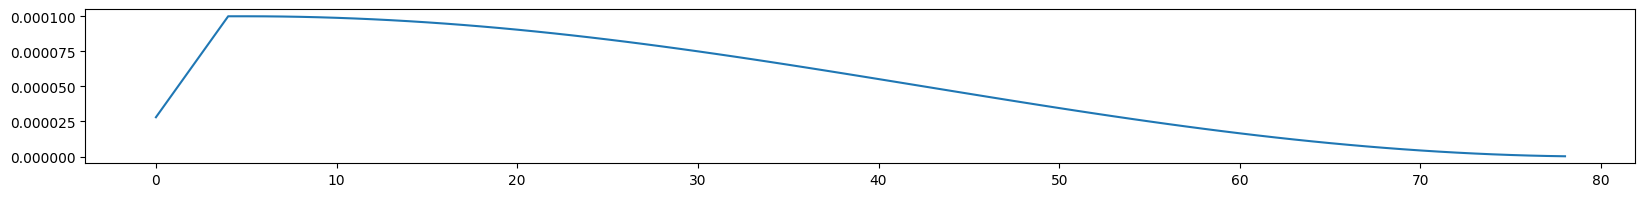

In [25]:
# model = CNN(backbone=backbone, pretrained=False)
model = TimmSED(
            base_model_name=config.base_model_name,
            config=config,
            pretrained=config.pretrained,
            num_classes=config.num_classes,
            in_channels=config.in_channels
        )


rcParams['figure.figsize'] = 20, 2

optimizer = AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

lrs = []
for epoch in range(1, n_epochs):
    scheduler_warmup.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(range(len(lrs)), lrs)

In [26]:

def train_fold():
    logger = init_logger(log_file=os.path.join(output_folder, exp_name, f"{fold}.log"))

    logger.info("=" * 90)
    logger.info(f"Fold {fold} Training")
    logger.info("=" * 90)

    trn_df = df[df['fold'] != fold].reset_index(drop=True)
    val_df = df[df['fold'] == fold].reset_index(drop=True)
#     print(trn_df.shape)
    logger.info(trn_df.shape)
    logger.info(trn_df['primary_label'].value_counts())
    logger.info(val_df.shape)
    logger.info(val_df['primary_label'].value_counts())


    # trn_dataset = BirdDataset(df=trn_df.reset_index(drop=True), transform=transforms_train, add_secondary_labels=True, mode='train')
    # v_ds = BirdDataset(df=val_df.reset_index(drop=True), transform=transforms_val, add_secondary_labels=True, mode='valid')
    trn_dataset = BirdDataset(df=trn_df.reset_index(drop=True), transform=transforms_train, add_secondary_labels=True)
    v_ds = BirdDataset(df=val_df.reset_index(drop=True), transform=transforms_val, add_secondary_labels=True)

    train_loader = torch.utils.data.DataLoader(trn_dataset, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=num_workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(v_ds, shuffle=False, batch_size=batch_size, drop_last=False, num_workers=num_workers, pin_memory=True)

    if CNN_:
        model = CNN(backbone=backbone, pretrained=True).to(device)
    else:
        model = TimmSED(
                base_model_name=config.base_model_name,
                config=config,
                pretrained=config.pretrained,
                num_classes=config.num_classes,
                in_channels=config.in_channels
            ).to(device)
    
    optimizer = AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    patience = early_stopping
    best_score = 0.0
    n_patience = 0

    for epoch in range(1, n_epochs + 1):
        # if epoch==5: break
        print(time.ctime(), 'Epoch:', epoch)

        scheduler_warmup.step(epoch-1)

        train_scores, train_losses_avg = train_one_epoch(model, train_loader, optimizer, scaler,epoch)
        train_scores_str = metrics_to_string(train_scores, "Train")
        train_info = f"Epoch {epoch} - Train loss: {train_losses_avg:.4f}, {train_scores_str}"
        logger.info(train_info)

        val_scores, val_losses_avg = valid_one_epoch(model, val_loader)
        val_scores_str = metrics_to_string(val_scores, f"Valid")
        val_info = f"Epoch {epoch} - Valid loss: {val_losses_avg:.4f}, {val_scores_str}"
        logger.info(val_info)

        val_score = val_scores["ROC"]

        is_better = val_score > best_score
        best_score = max(val_score, best_score)

        if is_better:
            state = {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "best_loss": best_score,
                "optimizer": optimizer.state_dict(),
            }
            logger.info(
                f"Epoch {epoch} - Save Best Score: {best_score:.4f} Model\n")
            torch.save(
                state,
                os.path.join(output_folder, exp_name, f"{fold}.bin")
            )
            n_patience = 0
        else:
            n_patience += 1
            logger.info(
                f"Valid loss didn't improve last {n_patience} epochs.\n")

        if n_patience >= patience:
            logger.info(
                "Early stop, Training End.\n")
            state = {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "best_loss": best_score,
                "optimizer": optimizer.state_dict(),
            }
            torch.save(
                state,
                os.path.join(output_folder, exp_name, f"final_{fold}.bin")
            )
            break

    del model
    torch.cuda.empty_cache()
    gc.collect()

base  0.9704

In [27]:
train_fold()

Fold 2 Training
(19567, 14)
primary_label
zitcis1    400
lirplo     400
litgre1    400
comgre     400
comkin1    400
          ... 
paisto1      5
blaeag1      5
asiope1      4
integr       4
niwpig1      4
Name: count, Length: 182, dtype: int64
(4892, 14)
primary_label
zitcis1    100
lirplo     100
comgre     100
comkin1    100
commoo3    100
          ... 
darter2      1
asiope1      1
wbbfly1      1
integr       1
blaeag1      1
Name: count, Length: 182, dtype: int64


load from local
load from local 2
323 323
Wed May 15 23:06:43 2024 Epoch: 1


100%|██████████| 305/305 [00:43<00:00,  7.02it/s, grad=9.94e+3, loss=0.88, lr=1e-5] 
Epoch 1 - Train loss: 0.8799, Train cmAP_1 : 0.5163, Train cmAP_5 : 0.7286, Train ROC : 0.8287, 
100%|██████████| 77/77 [00:13<00:00,  5.88it/s, loss=0.193]
Epoch 1 - Valid loss: 0.1930, Valid cmAP_1 : 0.5268, Valid cmAP_5 : 0.6873, Valid ROC : 0.9097, 
Epoch 1 - Save Best Score: 0.9097 Model



Wed May 15 23:07:44 2024 Epoch: 2


100%|██████████| 305/305 [00:42<00:00,  7.19it/s, grad=584, loss=0.0634, lr=2.8e-5]  
Epoch 2 - Train loss: 0.0634, Train cmAP_1 : 0.5310, Train cmAP_5 : 0.7404, Train ROC : 0.8425, 
100%|██████████| 77/77 [00:12<00:00,  6.30it/s, loss=0.0228]
Epoch 2 - Valid loss: 0.0228, Valid cmAP_1 : 0.5321, Valid cmAP_5 : 0.6923, Valid ROC : 0.9328, 
Epoch 2 - Save Best Score: 0.9328 Model



Wed May 15 23:08:42 2024 Epoch: 3


100%|██████████| 305/305 [00:44<00:00,  6.93it/s, grad=423, loss=0.0279, lr=4.6e-5]
Epoch 3 - Train loss: 0.0279, Train cmAP_1 : 0.5456, Train cmAP_5 : 0.7408, Train ROC : 0.9514, 
100%|██████████| 77/77 [00:12<00:00,  6.23it/s, loss=0.0196]
Epoch 3 - Valid loss: 0.0196, Valid cmAP_1 : 0.5636, Valid cmAP_5 : 0.7168, Valid ROC : 0.9452, 
Epoch 3 - Save Best Score: 0.9452 Model



Wed May 15 23:09:43 2024 Epoch: 4


100%|██████████| 305/305 [00:46<00:00,  6.56it/s, grad=414, loss=0.0258, lr=6.4e-5]
Epoch 4 - Train loss: 0.0258, Train cmAP_1 : 0.5482, Train cmAP_5 : 0.7578, Train ROC : 0.9589, 
100%|██████████| 77/77 [00:13<00:00,  5.88it/s, loss=0.0183]
Epoch 4 - Valid loss: 0.0183, Valid cmAP_1 : 0.5904, Valid cmAP_5 : 0.7353, Valid ROC : 0.9538, 
Epoch 4 - Save Best Score: 0.9538 Model



Wed May 15 23:10:47 2024 Epoch: 5


100%|██████████| 305/305 [00:44<00:00,  6.92it/s, grad=399, loss=0.0243, lr=8.2e-5]
Epoch 5 - Train loss: 0.0243, Train cmAP_1 : 0.5423, Train cmAP_5 : 0.7508, Train ROC : 0.9684, 
100%|██████████| 77/77 [00:12<00:00,  5.99it/s, loss=0.0175]
Epoch 5 - Valid loss: 0.0175, Valid cmAP_1 : 0.5999, Valid cmAP_5 : 0.7418, Valid ROC : 0.9575, 
Epoch 5 - Save Best Score: 0.9575 Model



Wed May 15 23:11:48 2024 Epoch: 6


100%|██████████| 305/305 [00:43<00:00,  7.09it/s, grad=357, loss=0.0237, lr=0.0001]
Epoch 6 - Train loss: 0.0237, Train cmAP_1 : 0.5198, Train cmAP_5 : 0.7321, Train ROC : 0.9587, 
100%|██████████| 77/77 [00:12<00:00,  6.10it/s, loss=0.0162]
Epoch 6 - Valid loss: 0.0162, Valid cmAP_1 : 0.6170, Valid cmAP_5 : 0.7529, Valid ROC : 0.9605, 
Epoch 6 - Save Best Score: 0.9605 Model



Wed May 15 23:12:48 2024 Epoch: 7


100%|██████████| 305/305 [00:43<00:00,  6.99it/s, grad=1.04e+3, loss=0.0228, lr=0.0001]
Epoch 7 - Train loss: 0.0228, Train cmAP_1 : 0.5220, Train cmAP_5 : 0.7326, Train ROC : 0.9702, 
100%|██████████| 77/77 [00:13<00:00,  5.84it/s, loss=0.0159]
Epoch 7 - Valid loss: 0.0159, Valid cmAP_1 : 0.6241, Valid cmAP_5 : 0.7574, Valid ROC : 0.9631, 
Epoch 7 - Save Best Score: 0.9631 Model



Wed May 15 23:13:49 2024 Epoch: 8


100%|██████████| 305/305 [00:45<00:00,  6.70it/s, grad=707, loss=0.0226, lr=9.98e-5]    
Epoch 8 - Train loss: 0.0226, Train cmAP_1 : 0.5266, Train cmAP_5 : 0.7350, Train ROC : 0.9670, 
100%|██████████| 77/77 [00:12<00:00,  5.94it/s, loss=0.0158]
Epoch 8 - Valid loss: 0.0158, Valid cmAP_1 : 0.6271, Valid cmAP_5 : 0.7598, Valid ROC : 0.9634, 
Epoch 8 - Save Best Score: 0.9634 Model



Wed May 15 23:14:52 2024 Epoch: 9


100%|██████████| 305/305 [00:43<00:00,  6.99it/s, grad=905, loss=0.0229, lr=9.96e-5]    
Epoch 9 - Train loss: 0.0229, Train cmAP_1 : 0.5924, Train cmAP_5 : 0.7823, Train ROC : 0.9729, 
100%|██████████| 77/77 [00:12<00:00,  6.01it/s, loss=0.0153]
Epoch 9 - Valid loss: 0.0153, Valid cmAP_1 : 0.6326, Valid cmAP_5 : 0.7629, Valid ROC : 0.9655, 
Epoch 9 - Save Best Score: 0.9655 Model



Wed May 15 23:15:52 2024 Epoch: 10


100%|██████████| 305/305 [00:44<00:00,  6.91it/s, grad=726, loss=0.0224, lr=9.93e-5]    
Epoch 10 - Train loss: 0.0224, Train cmAP_1 : 0.5760, Train cmAP_5 : 0.7708, Train ROC : 0.9775, 
100%|██████████| 77/77 [00:12<00:00,  5.98it/s, loss=0.0155]
Epoch 10 - Valid loss: 0.0155, Valid cmAP_1 : 0.6312, Valid cmAP_5 : 0.7626, Valid ROC : 0.9650, 
Valid loss didn't improve last 1 epochs.



Wed May 15 23:16:53 2024 Epoch: 11


100%|██████████| 305/305 [00:43<00:00,  6.99it/s, grad=678, loss=0.0226, lr=9.89e-5]    
Epoch 11 - Train loss: 0.0226, Train cmAP_1 : 0.5743, Train cmAP_5 : 0.7641, Train ROC : 0.9779, 
100%|██████████| 77/77 [00:12<00:00,  6.08it/s, loss=0.0157]
Epoch 11 - Valid loss: 0.0157, Valid cmAP_1 : 0.6320, Valid cmAP_5 : 0.7633, Valid ROC : 0.9649, 
Valid loss didn't improve last 2 epochs.



Wed May 15 23:17:53 2024 Epoch: 12


100%|██████████| 305/305 [00:43<00:00,  7.02it/s, grad=679, loss=0.0224, lr=9.84e-5]    
Epoch 12 - Train loss: 0.0224, Train cmAP_1 : 0.5963, Train cmAP_5 : 0.7789, Train ROC : 0.9801, 
100%|██████████| 77/77 [00:12<00:00,  6.01it/s, loss=0.0154]
Epoch 12 - Valid loss: 0.0154, Valid cmAP_1 : 0.6380, Valid cmAP_5 : 0.7675, Valid ROC : 0.9661, 
Epoch 12 - Save Best Score: 0.9661 Model



Wed May 15 23:18:54 2024 Epoch: 13


100%|██████████| 305/305 [00:43<00:00,  7.00it/s, grad=636, loss=0.0215, lr=9.79e-5]    
Epoch 13 - Train loss: 0.0215, Train cmAP_1 : 0.5380, Train cmAP_5 : 0.7479, Train ROC : 0.9702, 
100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0149]
Epoch 13 - Valid loss: 0.0149, Valid cmAP_1 : 0.6449, Valid cmAP_5 : 0.7716, Valid ROC : 0.9674, 
Epoch 13 - Save Best Score: 0.9674 Model



Wed May 15 23:19:55 2024 Epoch: 14


100%|██████████| 305/305 [00:43<00:00,  7.00it/s, grad=1.54e+3, loss=0.0215, lr=9.72e-5]
Epoch 14 - Train loss: 0.0215, Train cmAP_1 : 0.5827, Train cmAP_5 : 0.7773, Train ROC : 0.9756, 
100%|██████████| 77/77 [00:13<00:00,  5.67it/s, loss=0.0149]
Epoch 14 - Valid loss: 0.0149, Valid cmAP_1 : 0.6456, Valid cmAP_5 : 0.7724, Valid ROC : 0.9687, 
Epoch 14 - Save Best Score: 0.9687 Model



Wed May 15 23:20:56 2024 Epoch: 15


100%|██████████| 305/305 [00:43<00:00,  7.03it/s, grad=1.27e+3, loss=0.0213, lr=9.65e-5]
Epoch 15 - Train loss: 0.0213, Train cmAP_1 : 0.5657, Train cmAP_5 : 0.7677, Train ROC : 0.9723, 
100%|██████████| 77/77 [00:12<00:00,  6.20it/s, loss=0.0151]
Epoch 15 - Valid loss: 0.0151, Valid cmAP_1 : 0.6435, Valid cmAP_5 : 0.7702, Valid ROC : 0.9678, 
Valid loss didn't improve last 1 epochs.



Wed May 15 23:21:56 2024 Epoch: 16


100%|██████████| 305/305 [00:47<00:00,  6.46it/s, grad=1.14e+3, loss=0.0214, lr=9.57e-5]
Epoch 16 - Train loss: 0.0214, Train cmAP_1 : 0.5512, Train cmAP_5 : 0.7558, Train ROC : 0.9792, 
100%|██████████| 77/77 [00:12<00:00,  6.11it/s, loss=0.0149]
Epoch 16 - Valid loss: 0.0149, Valid cmAP_1 : 0.6476, Valid cmAP_5 : 0.7737, Valid ROC : 0.9687, 
Valid loss didn't improve last 2 epochs.



Wed May 15 23:23:00 2024 Epoch: 17


100%|██████████| 305/305 [00:44<00:00,  6.80it/s, grad=1.89e+3, loss=0.0205, lr=9.48e-5]
Epoch 17 - Train loss: 0.0205, Train cmAP_1 : 0.5471, Train cmAP_5 : 0.7516, Train ROC : 0.9747, 
100%|██████████| 77/77 [00:12<00:00,  6.00it/s, loss=0.0148]
Epoch 17 - Valid loss: 0.0148, Valid cmAP_1 : 0.6483, Valid cmAP_5 : 0.7738, Valid ROC : 0.9686, 
Valid loss didn't improve last 3 epochs.



Wed May 15 23:24:02 2024 Epoch: 18


100%|██████████| 305/305 [00:43<00:00,  6.98it/s, grad=1.19e+3, loss=0.0213, lr=9.38e-5]
Epoch 18 - Train loss: 0.0213, Train cmAP_1 : 0.5617, Train cmAP_5 : 0.7604, Train ROC : 0.9754, 
100%|██████████| 77/77 [00:13<00:00,  5.82it/s, loss=0.0148]
Epoch 18 - Valid loss: 0.0148, Valid cmAP_1 : 0.6512, Valid cmAP_5 : 0.7757, Valid ROC : 0.9685, 
Valid loss didn't improve last 4 epochs.



Wed May 15 23:25:03 2024 Epoch: 19


100%|██████████| 305/305 [00:44<00:00,  6.79it/s, grad=1.05e+3, loss=0.0206, lr=9.28e-5]
Epoch 19 - Train loss: 0.0206, Train cmAP_1 : 0.5160, Train cmAP_5 : 0.7307, Train ROC : 0.9847, 
100%|██████████| 77/77 [00:12<00:00,  5.98it/s, loss=0.015] 
Epoch 19 - Valid loss: 0.0150, Valid cmAP_1 : 0.6510, Valid cmAP_5 : 0.7753, Valid ROC : 0.9682, 
Valid loss didn't improve last 5 epochs.



Wed May 15 23:26:05 2024 Epoch: 20


100%|██████████| 305/305 [00:45<00:00,  6.76it/s, grad=3.31e+3, loss=0.0204, lr=9.16e-5]
Epoch 20 - Train loss: 0.0204, Train cmAP_1 : 0.5729, Train cmAP_5 : 0.7677, Train ROC : 0.9806, 
100%|██████████| 77/77 [00:13<00:00,  5.88it/s, loss=0.0144]
Epoch 20 - Valid loss: 0.0144, Valid cmAP_1 : 0.6574, Valid cmAP_5 : 0.7795, Valid ROC : 0.9692, 
Epoch 20 - Save Best Score: 0.9692 Model



Wed May 15 23:27:07 2024 Epoch: 21


100%|██████████| 305/305 [00:44<00:00,  6.85it/s, grad=4.07e+3, loss=0.0112, lr=9.05e-5]
Epoch 21 - Train loss: 0.0112, Train cmAP_1 : 0.6973, Train cmAP_5 : 0.7563, Train ROC : 0.9890, 
100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0142]
Epoch 21 - Valid loss: 0.0142, Valid cmAP_1 : 0.6627, Valid cmAP_5 : 0.7826, Valid ROC : 0.9701, 
Epoch 21 - Save Best Score: 0.9701 Model



Wed May 15 23:28:09 2024 Epoch: 22


 69%|██████▉   | 211/305 [00:32<00:09,  9.79it/s, grad=3.85e+3, loss=0.011, lr=8.92e-5] 

In [ ]:
import torchlibrosa

In [ ]:
torchlibrosa.SpecAugmentation